In [13]:
import os
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, MaxPooling2D, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

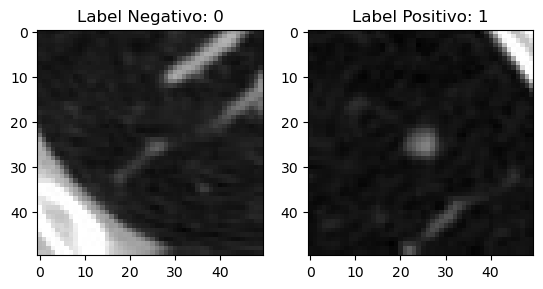

In [14]:
#observamos las imágenes
plt.subplot(1, 2, 1)
plt.title('Label Negativo: 0')
plt.imshow(cv2.imread('data\\images\\image_1054.jpg'))

plt.subplot(1, 2, 2)
plt.title('Label Positivo: 1')
plt.imshow(cv2.imread('data\\images\\image_13.jpg'))

plt.show()

## Pre-procesamiento de los Datos
Unir en un solo dataset las imagenes con sus labels

In [15]:
df = pd.read_csv('data\\labels.txt', sep=" ", header = None)
df.columns =['filepaths', 'labels']
df.head()

,filepaths,labels
0,data/images/image_189342.jpg,0
1,data/images/image_145102.jpg,0
2,data/images/image_31546.jpg,0
3,data/images/image_441280.jpg,1
4,data/images/image_215578.jpg,0


In [16]:
df = shuffle(df).reset_index(drop = True)
print (df['labels'].value_counts())

0    6755
1    1351
Name: labels, dtype: int64


In [17]:
# Se separan los datos en training, validacion y test
X_train, X_test, y_train, y_test = train_test_split(df['filepaths'], df['labels'], test_size=0.30, random_state=33)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, train_size=0.5, random_state=34)

print('Cantidad de datos en cada set\n')
print('Training:', len(y_train), '\t\t0:', y_train.value_counts()[0],', 1:' ,y_train.value_counts()[1])
print('Validacion:', len(y_val), '\t0:', y_val.value_counts()[0],', 1:' ,y_val.value_counts()[1])
print('Test:', len(y_test), '\t\t0:', y_test.value_counts()[0],', 1:' ,y_test.value_counts()[1])

Cantidad de datos en cada set

Training: 5674 		0: 4726 , 1: 948
Validacion: 1216 	0: 1023 , 1: 193
Test: 1216 		0: 1006 , 1: 210


## Pre-procesamiento de las imagenes

In [18]:
IMG_SIZE = 50

def preprocessig_data(data):
    X = []
    for img_path in data:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Pasamos la imagen a escala de grises
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0 # normalizamos los pixeles de la imagen
        X.append(img)
    X = np.array(X)
    X = X.reshape((-1, IMG_SIZE, IMG_SIZE, 1)) #Hacemos un reshape de las imagenes
    return X

X_train = preprocessig_data(X_train)
X_val = preprocessig_data(X_val)

In [19]:
# Usamos labelEncoder para manejar los labels como numeros
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

## Red convolucional de al menos 3 capas convolucionales

In [20]:
model_base = tf.keras.models.Sequential([
  
  Conv2D(30, kernel_size= (3,3), activation='relu', input_shape =(IMG_SIZE,IMG_SIZE,1)),
  MaxPooling2D(),

  Conv2D(20, kernel_size = (3,3), activation='relu'),
  MaxPooling2D(),

  Conv2D(20, kernel_size = (3,3), activation='relu'),
  MaxPooling2D(),
  
  Flatten(),
  Dense(100, activation='relu'),
  Dropout(0.2),
  
  Dense(1, activation= 'sigmoid') # Se tienen 2 posibles clases
])

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_base.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
model_base.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 30)        300       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 30)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 20)        5420      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 20)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 20)          3620      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 20)        

In [21]:
history_base = model_base.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size=40, epochs = 1000, callbacks=[early])
model_base.save('conv_model_1_p.h5')

Epoch 1/1000
142/142 [==============================] - 14s 93ms/step - loss: 0.4468 - accuracy: 0.8317 - val_loss: 0.3815 - val_accuracy: 0.8503
Epoch 2/1000
142/142 [==============================] - 10s 74ms/step - loss: 0.3509 - accuracy: 0.8551 - val_loss: 0.3475 - val_accuracy: 0.8586
Epoch 3/1000
142/142 [==============================] - 12s 86ms/step - loss: 0.3200 - accuracy: 0.8636 - val_loss: 0.3070 - val_accuracy: 0.8676
Epoch 4/1000
142/142 [==============================] - 10s 73ms/step - loss: 0.2899 - accuracy: 0.8793 - val_loss: 0.2806 - val_accuracy: 0.8766
Epoch 5/1000
142/142 [==============================] - 10s 69ms/step - loss: 0.2627 - accuracy: 0.8911 - val_loss: 0.2557 - val_accuracy: 0.8923
Epoch 6/1000
142/142 [==============================] - 11s 74ms/step - loss: 0.2494 - accuracy: 0.9010 - val_loss: 0.2451 - val_accuracy: 0.8972
Epoch 7/1000
142/142 [==============================] - 9s 66ms/step - loss: 0.2207 - accuracy: 0.9094 - val_loss: 0.2515 - 

In [22]:
# Evaluacion del modelo con el conjunto de Test
X_test= preprocessig_data(X_test)
y_test = le.transform(y_test)

In [23]:
score = model_base.evaluate(X_test, y_test)
print(f'Test loss: {score[0]}\nTest Accuracy: {score[1]}')

38/38 [==============================] - 1s 14ms/step - loss: 0.3143 - accuracy: 0.9005
Test loss: 0.3143116533756256
Test Accuracy: 0.9004934430122375


## Deploy del modelo: red convolucional

In [24]:
model_load = load_model('conv_model_1_p.h5')
def prep_img(img_path):
    IMG_SIZE = 50
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0

    img = np.array(img)

    img = img.reshape(-1,img.shape[0], img.shape[1], 1)
    return img

image_to_classify = prep_img('data\\images\\image_13.jpg')

In [25]:
order = ['Negativo', 'Positivo']
print(f'Clasification = {order[np.argmax(model_load.predict(image_to_classify))]}')

1/1 [==============================] - 0s 165ms/step
Clasification = Negativo
